# Simulated Galaxies: The Return

What we want in this notebook is to create and test several schemes to generate galaxy images. 

In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
import tensorflow as tf
import tensorflow_datasets as tfds
import autometacal
import tqdm
from scipy.stats import truncnorm
import os

## Original

In [3]:
def make_data(Ngals=1,
  snr = 100,
  scale = 0.2,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0], 
  flux=1.e5):
  """Simple exponetial profile toy model galaxy"""
  
  gal_list = []
  psf_list = []
 
  for n in range(Ngals):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)
    obj0 = galsim.Exponential(half_light_radius=gal_hlr,flux=flux).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr=snr,preserve_flux=True)
    
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
  
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  
  return gal_image_stack, psf_image_stack

get g1, g2:

In [4]:
gmax =.7 #max
gloc = 0 # mean
gsca = .3 #scatter
a, b = (-gmax - gloc) / gsca, (gmax - gloc) / gsca

g1=truncnorm.rvs(a, b, loc=gloc, scale=gsca,size=25)
g2=truncnorm.rvs(a, b, loc=gloc, scale=gsca,size=25)

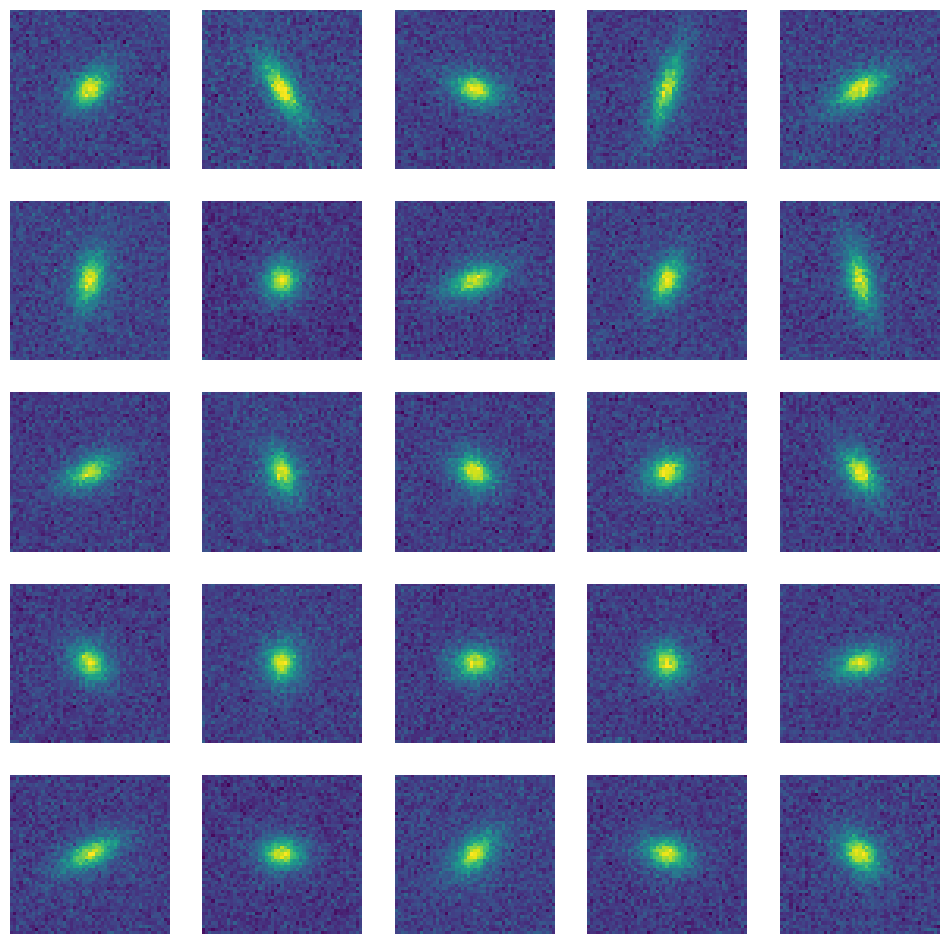

In [5]:
gal_images, _ = make_data(Ngals=25,scale=0.187,gal_g1=g1,gal_g2=g2)
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')

## Parametric COSMOS

In [6]:
seed = 31415
gal_rng = galsim.BaseDeviate(seed)


In [7]:
def make_parametric_cosmos(ccat,j):
  """Creates CFIS-like images out of the parametric COSMOS galaxies."""
  #CFIS
  psf_fwhm = .65 # arcsec
  sky_level = 400 # ADU (~variance)
  pixel_scale = 0.187 # arcsec/pixel
  mag_zp = 32
  stamp_size=51
 
  #get magnitude & flux
  gal_mag = 23#ccat.param_cat[j][1]
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)

  psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)
  
  gal = ccat.makeGalaxy(index=j,gal_type='parametric').withFlux(gal_flux)

  obj = galsim.Convolve((psf, gal))
  img = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=pixel_scale, method='fft')

  # Get snr
  S2 = np.sum(img.array**2)
  s2n = np.sqrt(S2/sky_level)

  noise = galsim.GaussianNoise(sigma=np.sqrt(sky_level), rng=gal_rng)
  img.addNoise(noise) # it updates directly the galsim object. It returns
                      # the variance if I remember well..

  #print(f"s2n: {s2n} (in galsim system)")
  return img.array, s2n, gal_mag

In [8]:
COSMOScat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'),use_real=False)

<ipython-input-9-a9dfcc8ead3e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gal_images = array([make_parametric_cosmos(COSMOScat,j) for j in arange(25)])


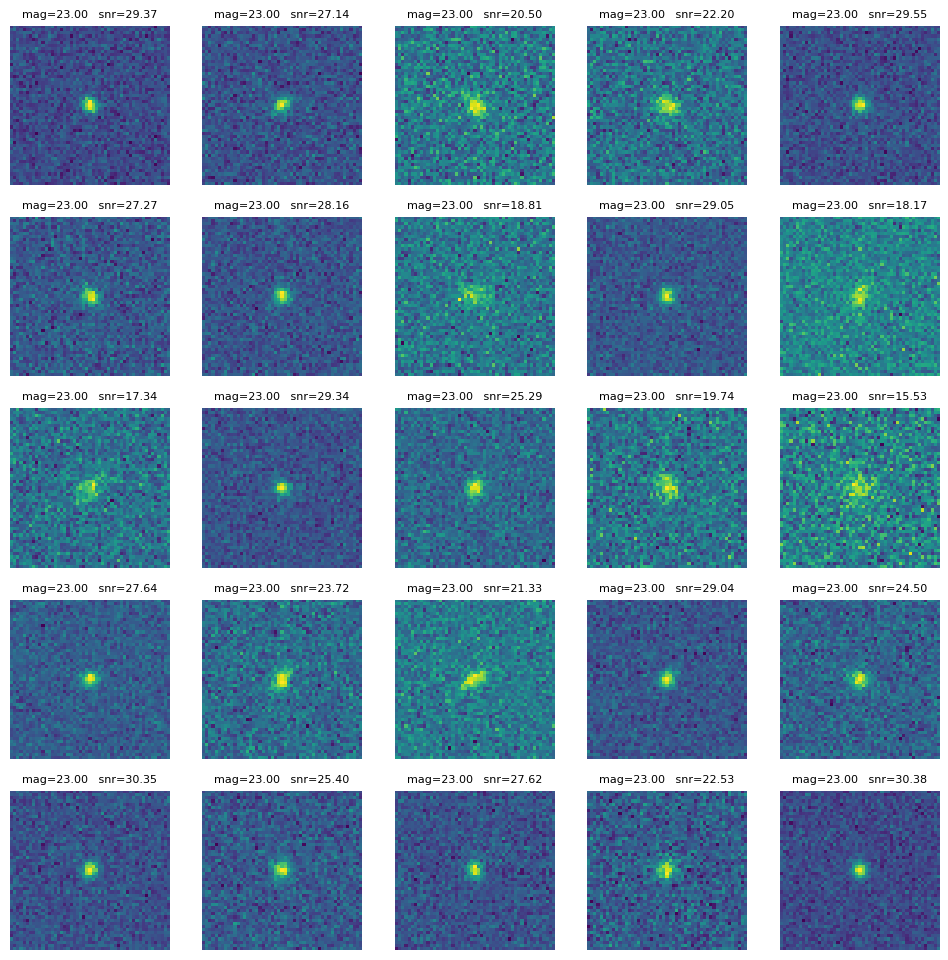

In [9]:
gal_images = array([make_parametric_cosmos(COSMOScat,j) for j in arange(25)])
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i][0])
  title(f'mag={gal_images[i][2]:.2f}   snr={gal_images[i][1]:.2f}',fontsize=8)
  axis('off')

## Real Images - I 

In [10]:
COSMOScat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'),use_real=True)

In [11]:
def make_cosmos_real(ccat,Ngals):
  """Just cutting stamps from the original gal image from HST"""
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  size=51

  while list_length < Ngals:
    gal=ccat.makeGalaxy(n)
        
    if (
      (min(gal.original_gal.image.array.shape) >= size) & 
      (min(gal.psf_image.array.shape) >= size) 
    ):
      centre_x_gal = gal.original_gal.image.array.shape[0]//2
      centre_y_gal = gal.original_gal.image.array.shape[1]//2
      
      centre_x_psf = gal.psf_image.array.shape[0]//2
      centre_y_psf = gal.psf_image.array.shape[1]//2
      
      psf_image = tf.convert_to_tensor(gal.psf_image.array[centre_x_psf - size //2 :
                                                           centre_x_psf + 1 + size //2 ,
                                                           centre_y_psf - size //2 :
                                                           centre_y_psf + 1 + size //2 ],
                                       dtype=tf.float32)
      gal_image = tf.convert_to_tensor(gal.gal_image.array[centre_x_gal - size //2 :
                                                           centre_x_gal + 1  + size //2,
                                                           centre_y_gal - size //2 :
                                                           centre_y_gal + 1 + size //2 ],
                                       dtype=tf.float32)
      gal_list.append(gal_image)
      psf_list.append(psf_image)
      list_length += 1
      
    else:
      print(min(gal.original_gal.image.array.shape),min(gal.psf_image.array.shape),end="\r")
    n += 1
    
      
  print()
  print(n)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [12]:
gal_images, _ =make_cosmos_real(COSMOScat,25)

33 51
47


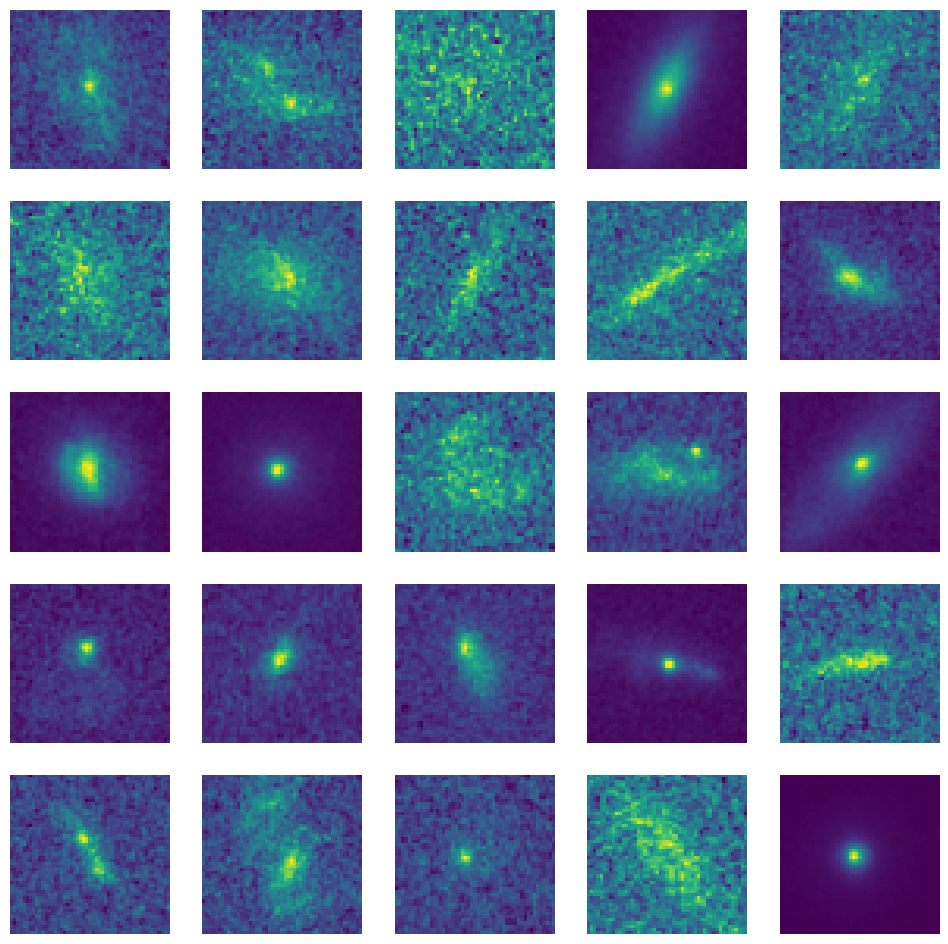

In [13]:
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')

## Real Images II

In [14]:
ccat.makeGalaxy?

Object `ccat.makeGalaxy` not found.


In [15]:
def make_cosmos_real2(ccat,Ngals):
  """Convolve the real galaxies with a PSF"""
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  #CFIS
  psf_fwhm = .65 # arcsec
  sky_level = 0 # ADU (~variance)
  pixel_scale = 0.187 # arcsec/pixel
  mag_zp = 32
  size=51
 
  #get magnitude & flux
  gal_mag = 23#ccat.param_cat[j][1]
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)

  for n in range(Ngals):
    ccat = COSMOScat
    gal = ccat.makeGalaxy(index=n,gal_type='real')

    psf = galsim.Kolmogorov(fwhm=.6).withFlux(1.0)
    obs = galsim.Convolve([[gal,psf]])
    img = obs.drawImage(nx=size,ny=size)
    
    noise = galsim.GaussianNoise(sigma=np.sqrt(sky_level), rng=gal_rng)
    img.addNoise(noise)
    
    
    
    gal_list.append(img.array)
    psf_list.append(psf.drawImage(nx=51,ny=51).array)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [16]:
gal_images, _ = make_cosmos_real2(COSMOScat,25)

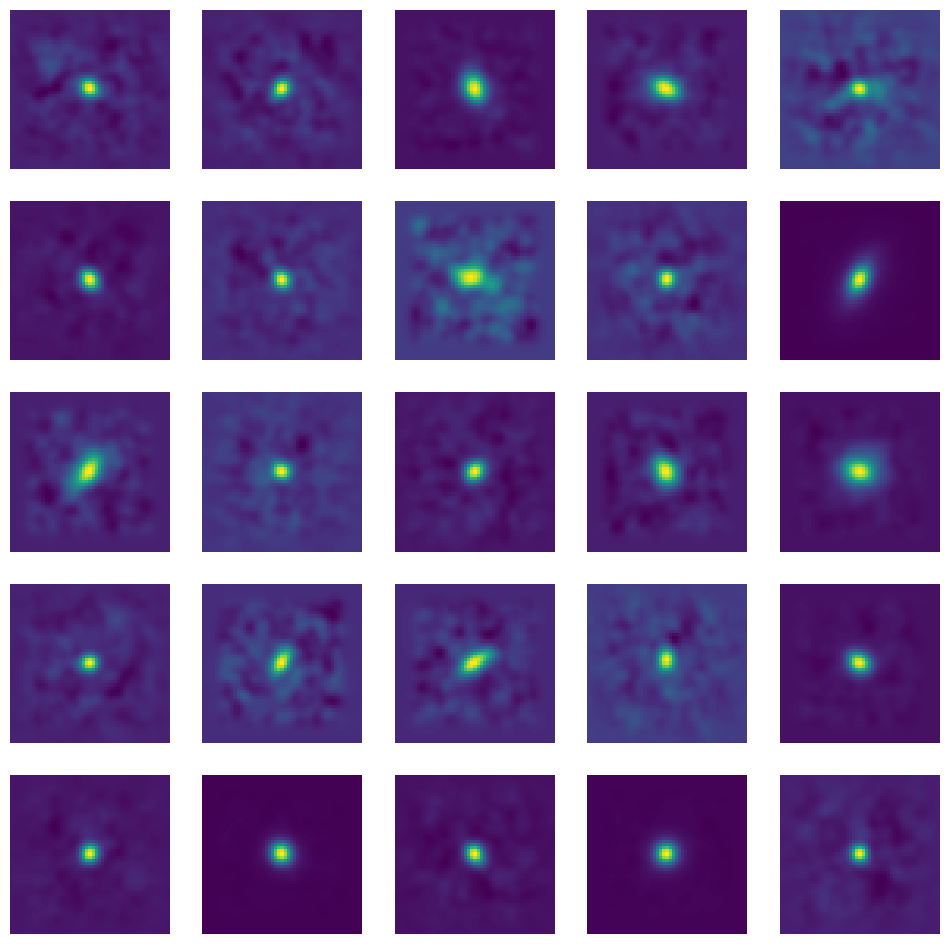

In [17]:
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')

In [8]:
import galsim
import os

In [40]:
def draw_and_encode_stamp(gal, psf, stamp_size, pixel_scale, attributes=None):
    """
    Draws the galaxy, psf and noise power spectrum on a postage stamp and
    encodes it to be exported in a TFRecord.
    """

    # Apply the PSF
    gal = galsim.Convolve(gal, psf)

    # Draw a kimage of the galaxy, just to figure out what maxk is, there might
    # be more efficient ways to do this though...
    bounds = _BoundsI(0, stamp_size//2, -stamp_size//2, stamp_size//2-1)
    imG = gal.drawKImage(bounds=bounds,
                         scale=2.*np.pi/(stamp_size * pixel_scale),
                         recenter=False)
    mask = ~(np.fft.fftshift(imG.array, axes=0) == 0)

    # We draw the pixel image of the convolved image
    im = gal.drawImage(nx=stamp_size, ny=stamp_size, scale=pixel_scale,
                       method='no_pixel', use_true_center=False).array.astype('float32')

    # Draw the Fourier domain image of the galaxy, using x1 zero padding,
    # and x2 subsampling
    interp_factor=2
    padding_factor=1
    Nk = stamp_size*interp_factor*padding_factor
    bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)
    imCp = psf.drawKImage(bounds=bounds,
                         scale=2.*np.pi/(Nk * pixel_scale / interp_factor),
                         recenter=False)

    # Transform the psf array into proper format, remove the phase
    im_psf = np.abs(np.fft.fftshift(imCp.array, axes=0)).astype('float32')

    # Compute noise power spectrum, at the resolution and stamp size of target
    # image
    ps = gal.noise._get_update_rootps((stamp_size, stamp_size),
                                       wcs=galsim.PixelScale(pixel_scale))

    # The following comes from correlatednoise.py
    rt2 = np.sqrt(2.)
    shape = (stamp_size, stamp_size)
    ps[0, 0] = rt2 * ps[0, 0]
    # Then make the changes necessary for even sized arrays
    if shape[1] % 2 == 0:  # x dimension even
        ps[0, shape[1] // 2] = rt2 * ps[0, shape[1] // 2]
    if shape[0] % 2 == 0:  # y dimension even
        ps[shape[0] // 2, 0] = rt2 * ps[shape[0] // 2, 0]
        # Both dimensions even
        if shape[1] % 2 == 0:
            ps[shape[0] // 2, shape[1] // 2] = rt2 * \
                ps[shape[0] // 2, shape[1] // 2]

    # Apply mask to power spectrum so that it is very large outside maxk
    ps = np.where(mask, np.log(ps**2), 10).astype('float32')
    serialized_output = {"image/encoded": [im.tostring()],
            "image/format": ["raw"],
            "psf/encoded": [im_psf.tostring()],
            "psf/format": ["raw"],
            "ps/encoded": [ps.tostring()],
            "ps/format": ["raw"]}

    # Adding the parameters provided
    if attributes is not None:
        for k in attributes:
            serialized_output['attrs/'+k] = [attributes[k]]

    return serialized_output

def generator():
    """
    Generates and yields postage stamps obtained with GalSim.
    """


    # If that fails, tries to use the specified tmp_dir
    catalog = galsim.COSMOSCatalog(dir=os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))

    # Create a list of galaxy indices for this task, remember, there is a task
    # per shard, each shard is 1000 galaxies.


    # Extracts additional information about the galaxies
    cat_param = catalog.param_cat[catalog.orig_index]
    from numpy.lib.recfunctions import append_fields
    import numpy as np

    bparams = cat_param['bulgefit']
    sparams = cat_param['sersicfit']
    # Parameters for a 2 component fit
    cat_param = append_fields(cat_param, 'bulge_q', bparams[:,11])
    cat_param = append_fields(cat_param, 'bulge_beta', bparams[:,15])
    cat_param = append_fields(cat_param, 'disk_q', bparams[:,3])
    cat_param = append_fields(cat_param, 'disk_beta', bparams[:,7])
    cat_param = append_fields(cat_param, 'bulge_hlr', cat_param['hlr'][:,1])
    cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
    cat_param = append_fields(cat_param, 'disk_hlr', cat_param['hlr'][:,2])
    cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))

    # Parameters for a single component fit
    cat_param = append_fields(cat_param, 'sersic_flux_log10', np.log10(sparams[:,0]))
    cat_param = append_fields(cat_param, 'sersic_q', sparams[:,3])
    cat_param = append_fields(cat_param, 'sersic_hlr', sparams[:,1])
    cat_param = append_fields(cat_param, 'sersic_n', sparams[:,2])
    cat_param = append_fields(cat_param, 'sersic_beta', sparams[:,7])
    index = [ind for ind in range(10)]
    print("bangarang!")

    for ind in index:
      # Draw a galaxy using GalSim, any kind of operation can be done here
      gal = catalog.makeGalaxy(ind, noise_pad_size=p.img_len * p.pixel_scale*2)

      # Utility function encodes the postage stamp for serialized features
      return draw_and_encode_stamp(gal, psf,
                                               stamp_size=p.img_len,
                                               pixel_scale=p.pixel_scale,
                                               attributes=attributes)

In [41]:
generator()

<ipython-input-40-844666ee25c8>:96: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
<ipython-input-40-844666ee25c8>:98: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))


bangarang!


NameError: name 'p' is not defined

In [44]:
# If that fails, tries to use the specified tmp_dir
catalog = galsim.COSMOSCatalog(dir=os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))

# Create a list of galaxy indices for this task, remember, there is a task
# per shard, each shard is 1000 galaxies.


# Extracts additional information about the galaxies
cat_param = catalog.param_cat[catalog.orig_index]
from numpy.lib.recfunctions import append_fields
import numpy as np

bparams = cat_param['bulgefit']
sparams = cat_param['sersicfit']
# Parameters for a 2 component fit
cat_param = append_fields(cat_param, 'bulge_q', bparams[:,11])
cat_param = append_fields(cat_param, 'bulge_beta', bparams[:,15])
cat_param = append_fields(cat_param, 'disk_q', bparams[:,3])
cat_param = append_fields(cat_param, 'disk_beta', bparams[:,7])
cat_param = append_fields(cat_param, 'bulge_hlr', cat_param['hlr'][:,1])
cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
cat_param = append_fields(cat_param, 'disk_hlr', cat_param['hlr'][:,2])
cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))

# Parameters for a single component fit
cat_param = append_fields(cat_param, 'sersic_flux_log10', np.log10(sparams[:,0]))
cat_param = append_fields(cat_param, 'sersic_q', sparams[:,3])
cat_param = append_fields(cat_param, 'sersic_hlr', sparams[:,1])
cat_param = append_fields(cat_param, 'sersic_n', sparams[:,2])
cat_param = append_fields(cat_param, 'sersic_beta', sparams[:,7])
index = [ind for ind in range(10)]
print("bangarang!")



<ipython-input-44-1c7b09c9aae1>:21: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
<ipython-input-44-1c7b09c9aae1>:23: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))


bangarang!


In [45]:
for ind in index:
  # Draw a galaxy using GalSim, any kind of operation can be done here
  gal = catalog.makeGalaxy(ind, noise_pad_size=p.img_len * p.pixel_scale*2)

  # Utility function encodes the postage stamp for serialized features
  teste=draw_and_encode_stamp(gal, psf,
                                           stamp_size=p.img_len,
                                           pixel_scale=p.pixel_scale,
                                           attributes=attributes)

NameError: name 'p' is not defined

In [28]:
catalog = galsim.COSMOSCatalog(dir=os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))
cat_param = catalog.param_cat[catalog.orig_index]



In [29]:
from numpy.lib.recfunctions import append_fields

In [30]:
bparams = cat_param['bulgefit']
sparams = cat_param['sersicfit']

In [31]:
# Parameters for a 2 component fit
cat_param = append_fields(cat_param, 'bulge_q', bparams[:,11])
cat_param = append_fields(cat_param, 'bulge_beta', bparams[:,15])
cat_param = append_fields(cat_param, 'disk_q', bparams[:,3])
cat_param = append_fields(cat_param, 'disk_beta', bparams[:,7])
cat_param = append_fields(cat_param, 'bulge_hlr', cat_param['hlr'][:,1])
cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
cat_param = append_fields(cat_param, 'disk_hlr', cat_param['hlr'][:,2])
cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))

# Parameters for a single component fit
cat_param = append_fields(cat_param, 'sersic_flux_log10', np.log10(sparams[:,0]))
cat_param = append_fields(cat_param, 'sersic_q', sparams[:,3])
cat_param = append_fields(cat_param, 'sersic_hlr', sparams[:,1])
cat_param = append_fields(cat_param, 'sersic_n', sparams[:,2])
cat_param = append_fields(cat_param, 'sersic_beta', sparams[:,7])

<ipython-input-31-1f56b5cfab81>:7: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'bulge_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,1]), np.zeros(len(cat_param) )))
<ipython-input-31-1f56b5cfab81>:9: RuntimeWarning: divide by zero encountered in log10
  cat_param = append_fields(cat_param, 'disk_flux_log10', np.where(cat_param['use_bulgefit'] ==1, np.log10(cat_param['flux'][:,2]), np.log10(cat_param['flux'][:,0])))


In [33]:
from astropy.table import Table

In [35]:
tab_param=Table(cat_param)